In [19]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [20]:
# Function to warp the image 

def warp_image(im):

    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # visualise the colours in a RGB colour space
    H, S, V = cv2.split(im_hsv)

    # define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

    # Apply mask to visualise
    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    im_contours = im.copy()
    cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.02 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    # Order the corners
     # === Order the corner points ===
    ordered_corners = np.zeros((4, 2), dtype="float32")
    corners_sum = corners.sum(axis=1)
    corners_diff = np.diff(corners, axis=1)

    ordered_corners[0] = corners[np.argmin(corners_sum)]      
    ordered_corners[2] = corners[np.argmax(corners_sum)]      
    ordered_corners[1] = corners[np.argmin(corners_diff)]    
    ordered_corners[3] = corners[np.argmax(corners_diff)]    

    h = 300
    w = 400

    corner_points_output = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    M = cv2.getPerspectiveTransform(np.float32(ordered_corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return ordered_corners, warped_image

In [21]:
# Function to determine image state 

def find_game_state(warped_image): 

    warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

    H1, S1, V1 = cv2.split(warped_hsv)

    pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # Red mask
    lower1_red = (175,0,0)
    upper1_red = (200,255,255)

    lower2_red = (0,150,0)
    upper2_red = (10,255,255)

    mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
    mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

    red_mask = cv2.bitwise_or(mask1, mask2)


    # Yellow mask
    lower_yellow = (25,170,100)
    upper_yellow = (35,255,250)

    yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

    # # Apply mask to visualise
    im_red = warped_image.copy()
    im_red[(red_mask==0),:] = (0,0,0)

    im_yellow = warped_image.copy()
    im_yellow[(yellow_mask==0),:] = (0,0,0)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

    #Apply contour to find edges of the board 
    red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_red_contours = warped_image.copy()
    cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green


    yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
    yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_yellow_contours = warped_image.copy()
    cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

    (num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

    (num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

    game_state = np.zeros((6, 7))

    row_height = 50 
    col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

    for i in range(1, num_components_red): 
        cx, cy = red_centroids[i]

        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 2

    for i in range(1, num_components_yellow): 
        cx, cy = yellow_centroids[i]


        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 1


        

    return game_state

In [48]:
# Verification functions 

def find_board_accuracy(validation_data, image_path):

    image = cv2.imread(image_path)
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_label = os.path.basename(image_path)
    correct_array = validation_data[image_label]

    total_cells = 6*7

    # Warp image
    corners, warped_image = warp_image(im)

    # Find game state 
    game_state = find_game_state(warped_image)

    num_correct = np.sum(correct_array == game_state)
    board_accuracy = num_correct/total_cells

    return board_accuracy


def find_overall_accuracies(validation_data): 

    counter = 0
    total_images = 15

    all_accuracies = []

    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        board_accuracy = find_board_accuracy(validation_data, image_path)

        if board_accuracy == 1: 
            counter += 1
        
        all_accuracies.append(board_accuracy)
    
    overall_accuracy = counter/total_images
    average_accuracy = np.mean(all_accuracies)

    return overall_accuracy, average_accuracy


def find_corner_accuracy(validation_data): 

    corner_accuracies = []

    for i in range(1, 16):
        image_path = 'connect_four_images_A1/%03d.jpg'%i

        image = cv2.imread(image_path)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        corners, _ = warp_image(im)

        # Re-order corners 
        temp = corners[2].copy()
        corners[2] = corners[3]
        corners[3] = temp

        print(corners)

        true_corners = validation_data['%03d.jpg'%i]

        error = np.linalg.norm(corners - true_corners, axis=1)

        magnitude = np.linalg.norm(true_corners, axis=1)

        error_norm = np.mean(error/magnitude)

        accuracy = 1-error_norm



        corner_accuracies.append(accuracy)

    
    average_corner_accuracy = np.mean(corner_accuracies)

    return corner_accuracies, average_corner_accuracy

[[ 436. 1075.]
 [2135. 1152.]
 [1961. 2167.]
 [ 653. 2007.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0.]
 [0. 1. 2. 2. 0. 0. 0.]
 [1. 1. 2. 1. 0. 0. 0.]]


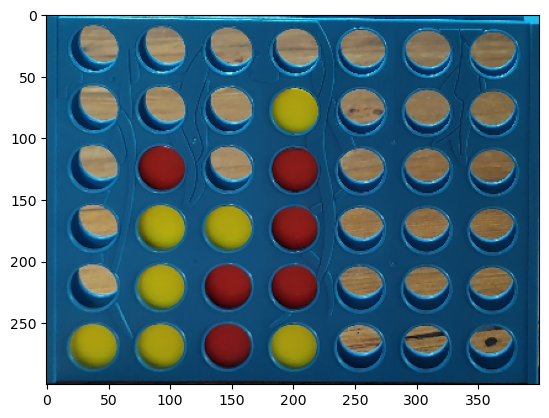

In [40]:
############## MAIN ############################################################

# Read in relevant files 
image_path = 'connect_four_images_A1/001.jpg'
image = cv2.imread(image_path)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open('assign1Q2_validationdata/board_states.pkl', 'rb') as f:
        validation_data = pickle.load(f)


# Warp image
corners, warped_image = warp_image(im)
plt.imshow(warped_image)

print(corners)

# Find game state 
game_state = find_game_state(warped_image)
print(game_state)

# Verify the board accuracy 
# board_accuracy = find_board_accuracy(validation_data, image_path)
# print("Board Accuracy:", board_accuracy)





In [24]:

overall_accuracy, average_accuracy = find_overall_accuracies(validation_data)

print("Average accuracy: ", average_accuracy)
print("Overall accuracy: ", overall_accuracy)

Average accuracy:  1.0
Overall accuracy:  1.0


In [50]:
# Finding accuracy of detected board corners 

with open('assign1Q2_validationdata/board_corners.pkl', 'rb') as f:
        corner_data = pickle.load(f)


print(corner_data)

corner_accuracies, average_corner_accuracy = find_corner_accuracy(corner_data)

print(corner_accuracies)
print("Average Corner Accuracy: ", average_corner_accuracy)


{'001.jpg': [[460, 1052], [2138, 1156], [650, 2002], [1964, 2162]], '002.jpg': [[378, 1062], [2226, 1014], [670, 2084], [2104, 2142]], '003.jpg': [[350, 948], [2306, 1010], [444, 2442], [2158, 2294]], '004.jpg': [[472, 972], [2176, 1114], [646, 1960], [1972, 2150]], '005.jpg': [[696, 638], [2320, 630], [772, 1758], [2170, 1828]], '006.jpg': [[416, 1290], [1758, 1256], [526, 2232], [1718, 2134]], '007.jpg': [[404, 864], [2476, 842], [576, 2308], [2244, 2130]], '008.jpg': [[78, 834], [2504, 830], [298, 2440], [2288, 2414]], '009.jpg': [[654, 698], [1976, 696], [750, 1648], [1884, 1614]], '010.jpg': [[862, 940], [2372, 942], [938, 1918], [2224, 1976]], '011.jpg': [[434, 752], [2118, 1018], [628, 1760], [1894, 2118]], '012.jpg': [[484, 1046], [2098, 968], [618, 2202], [1894, 1922]], '013.jpg': [[620, 682], [2294, 680], [746, 2028], [2116, 1790]], '014.jpg': [[308, 1028], [2332, 1020], [546, 2188], [2058, 2112]], '015.jpg': [[598, 1004], [2006, 1140], [732, 1854], [1864, 2052]]}
[[ 436. 107